In [1]:
# Ignore this block -- it's for the documentation build
try:
    import os, sys
    sys.path.insert(1, os.path.abspath('/home/runner/work/psi4/psi4/code/objdir/stage//usr/local/psi4/lib/'))
except ImportError:
    pass

# This is the important part
import psi4

In [2]:
%%time
psi4.set_output_file('output.dat', False)

CPU times: user 1.53 ms, sys: 0 ns, total: 1.53 ms
Wall time: 2.96 ms


PosixPath('output.dat')

In [3]:
%%time
#! Sample HF/cc-pVDZ H2O Computation

psi4.set_memory('500 MB')

h2o = psi4.geometry("""
O
H 1 0.96
H 1 0.96 2 104.5
""")

psi4.energy('scf/cc-pvdz')

CPU times: user 374 ms, sys: 66.1 ms, total: 440 ms
Wall time: 1.88 s


-76.0266327350902

In [4]:
%%time
#! Sample UHF/6-31G** CH2 Computation

R = 1.075
A = 133.93

ch2 = psi4.geometry("""
0 3
C
H 1 {0}
H 1 {0} 2 {1}
""".format(R, A)
)

psi4.set_options({'reference': 'uhf'})
psi4.energy('scf/6-31g**')


CPU times: user 286 ms, sys: 13.1 ms, total: 299 ms
Wall time: 305 ms


-38.92533462893707

In [5]:
%%time
psi4.set_options({'reference': 'rhf'})
psi4.optimize('scf/cc-pvdz', molecule=h2o)

Optimizer: Optimization complete!
CPU times: user 851 ms, sys: 48.4 ms, total: 900 ms
Wall time: 931 ms


-76.02703272937481

In [6]:
%%time
scf_e, scf_wfn = psi4.frequency('scf/cc-pvdz', molecule=h2o, return_wfn=True)

CPU times: user 1.01 s, sys: 60.4 ms, total: 1.07 s
Wall time: 1.1 s


In [10]:
%%time
# Example SAPT computation for ethene*ethyne (*i.e.*, ethylene*acetylene).
# Test case 16 from S22 Database

dimer = psi4.geometry("""
0 1
C   0.000000  -0.667578  -2.124659
C   0.000000   0.667578  -2.124659
H   0.923621  -1.232253  -2.126185
H  -0.923621  -1.232253  -2.126185
H  -0.923621   1.232253  -2.126185
H   0.923621   1.232253  -2.126185
--
0 1
C   0.000000   0.000000   2.900503
C   0.000000   0.000000   1.693240
H   0.000000   0.000000   0.627352
H   0.000000   0.000000   3.963929
units angstrom
""")

CPU times: user 1.17 ms, sys: 19 µs, total: 1.18 ms
Wall time: 1.19 ms


In [11]:
%%time
psi4.set_options({'scf_type': 'df',
                  'freeze_core': True})

psi4.energy('sapt0/jun-cc-pvdz', molecule=dimer)

CPU times: user 3.95 s, sys: 247 ms, total: 4.2 s
Wall time: 4.3 s


-0.0022355823909805178

In [13]:
%%time
#! Example potential energy surface scan and CP-correction for Ne2

ne2_geometry = """
Ne
--
Ne 1 {0}
"""

Rvals = [2.5, 3.0, 4.0]

psi4.set_options({'freeze_core': True})

# Initialize a blank dictionary of counterpoise corrected energies
# (Need this for the syntax below to work)

ecp = {}

for R in Rvals:
    ne2 = psi4.geometry(ne2_geometry.format(R))
    ecp[R] = psi4.energy('ccsd(t)/aug-cc-pvdz', bsse_type='cp', molecule=ne2)

# Prints to screen
print("CP-corrected CCSD(T)/aug-cc-pVDZ Interaction Energies\n\n")
print("          R [Ang]                 E_int [kcal/mol]       ")
print("---------------------------------------------------------")
for R in Rvals:
    e = ecp[R] * psi4.constants.hartree2kcalmol
    print("            {:3.1f}                        {:1.6f}".format(R, e))

# Prints to output.dat
psi4.core.print_out("CP-corrected CCSD(T)/aug-cc-pVDZ Interaction Energies\n\n")
psi4.core.print_out("          R [Ang]                 E_int [kcal/mol]       \n")
psi4.core.print_out("---------------------------------------------------------\n")
for R in Rvals:
    e = ecp[R] * psi4.constants.hartree2kcalmol
    psi4.core.print_out("            {:3.1f}                        {:1.6f}\n".format(R, e))

CP-corrected CCSD(T)/aug-cc-pVDZ Interaction Energies


          R [Ang]                 E_int [kcal/mol]       
---------------------------------------------------------
            2.5                        0.758605
            3.0                        0.015968
            4.0                        -0.016215
CPU times: user 5.36 s, sys: 1.63 s, total: 6.99 s
Wall time: 7.58 s


FileNotFoundError: [Errno 2] No such file or directory: 'Figures/argon_lj_potential.png'

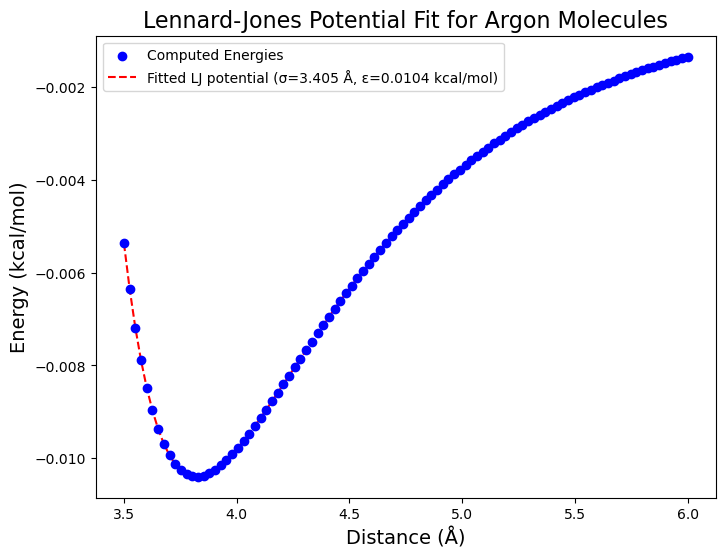

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Define the Lennard-Jones potential function
def lj(r, sigma, eps):
    return 4 * eps * ((sigma / r)**12 - (sigma / r)**6)

# Define the distances between the Argon molecules (in Angstroms)
distances = np.linspace(3.5, 6, 100)  # Distances from 3.5 to 6 Angstroms

# Let's assume some example computed energy values (for demonstration, you can replace these with actual data)
# For example purposes, I will generate synthetic energy data here.
eps_true = 0.0104  # Argon potential depth (in kcal/mol)
sigma_true = 3.405  # Argon distance parameter (in Angstroms)
energies = lj(distances, sigma_true, eps_true)  # This would be the energy of Argon molecules

# Now, fit the synthetic energy data to the Lennard-Jones potential function
popt, _ = curve_fit(lj, distances, energies, p0=[3.4, 0.01])  # Initial guess for sigma and eps

# Extract the fitted parameters
sigma_fit, eps_fit = popt

# Create the plot
plt.figure(figsize=(8, 6))

# Plot the computed energies as dots
plt.scatter(distances, energies, color='blue', label='Computed Energies', zorder=5)

# Plot the fitted Lennard-Jones potential as a dashed line
plt.plot(distances, lj(distances, *popt), 'r--', label=f'Fitted LJ potential (σ={sigma_fit:.3f} Å, ε={eps_fit:.4f} kcal/mol)', zorder=4)

# Labels and title
plt.xlabel('Distance (Å)', fontsize=14)
plt.ylabel('Energy (kcal/mol)', fontsize=14)
plt.title('Lennard-Jones Potential Fit for Argon Molecules', fontsize=16)

# Add a legend
plt.legend()

# Save the plot in the Figures directory
plt.savefig('Figures/argon_lj_potential.png', dpi=300)

# Show the plot
plt.show()

# Save the notebook in the Work directory (you can manually save the notebook in Jupyter)
